## Desigualdade de Gênero Mercado Formal

### Primeiros passos:

#### 1) Importação das bibliotecas

In [17]:
import basedosdados as bd
import pandas as pd
import numpy as np
import weightedstats as ws
import seaborn as sns
import matplotlib.pyplot as plt


#### 2) Baixando a base pela API 

query_agregado_vinculos = """
SELECT 
    sigla_uf,
    sexo_trabalhador,
    ano, 
    vinculo_ativo_3112,
    idade,
    numero_vinculos, 
    valor_remun_media_sm,
    valor_remun_media_nominal 
FROM `basedosdados.br_me_rais.agregado_vinculos_uf_vinculo_ativo_cbo_cnae_natureza_juridica_idade_sexo_raca` 
WHERE ano IN (1999, 2009, 2019) and valor_remun_media_nominal != 0.0 and idade >= 18 and vinculo_ativo_3112=1
"""


bd.download(query=query_agregado_vinculos, savepath="dados/agregado_vinculo", billing_project_id="processo-ufrj-analytica")

#### 3) Primeiro contato com a base

In [269]:
agregado_vinculos = pd.read_csv("dados/agregado_vinculo")
agregado_vinculos.head()

,sigla_uf,sexo_trabalhador,ano,vinculo_ativo_3112,idade,numero_vinculos,valor_remun_media_sm,valor_remun_media_nominal
0,RJ,1,1999,1,40,1,1.45,194.12
1,RJ,1,1999,1,48,1,1.96,262.47
2,RJ,1,1999,1,50,1,5.32,713.71
3,RJ,1,1999,1,33,1,2.05,275.00
4,RJ,1,1999,1,19,1,1.70,231.30


#### 4) Definindo variáveis importantes e funções

In [270]:
agrupado_sexo_ano = agregado_vinculos.groupby(by=[ "ano","sexo_trabalhador",])
agrupado_ano = agregado_vinculos.groupby("ano")

def pondera_media(df):
    return ws.numpy_weighted_mean(df["valor_remun_media_nominal"], weights=df["numero_vinculos"])

def pondera_mediana(df):
    return ws.numpy_weighted_median(df["valor_remun_media_nominal"], weights=df["numero_vinculos"])
    

### Pessoas no mercado formal: mulheres x homens:

In [276]:
num_vinculos_ano_sexo = agrupado_sexo_ano.numero_vinculos.sum().unstack()
num_vinculos_ano_sexo

sexo_trabalhador,1,2
ano,,
1999,14931320,9650145
2009,23794873,16872390
2019,25947222,20509798


#### 1) Gráfico: Mulheres e Homens no mercado formal

Text(0.5, 1.0, 'Mulheres e homens no mercado formal')

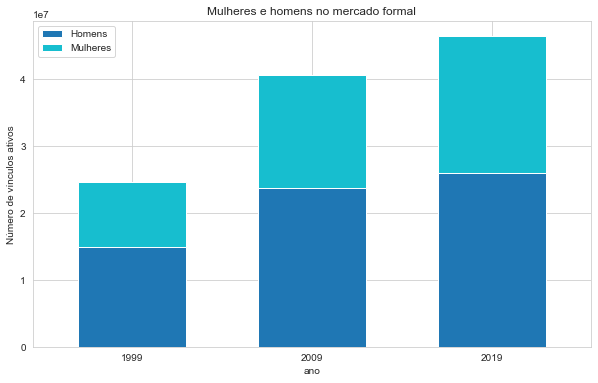

In [277]:
sns.set_style('whitegrid')
num_vinculos_ano_sexo.plot(kind='bar', stacked=True, color=['tab:blue', 'tab:cyan'], width=0.6, figsize=(10,6))
plt.xticks(rotation=0)
plt.ylabel('Número de vínculos ativos');
plt.legend(["Homens", "Mulheres"]);
plt.title("Mulheres e homens no mercado formal")


#### 2) Porcentagem de mulheres no mercado

In [278]:
vinculos_ano_mulheres = num_vinculos_ano_sexo[2]
num_vinculos_ano = agrupado_ano["numero_vinculos"].sum()
porc_vinc_mulheres = (vinculos_ano_mulheres/num_vinculos_ano)*100
porc_vinc_mulheres = porc_vinc_mulheres.rename("Porcentagem de vínculos de mulheres")
porc_vinc_mulheres

ano
1999    39.257811
2009    41.488875
2019    44.147898
Name: Porcentagem de vínculos de mulheres, dtype: float64

### Pessoas abaixo do salário mínimo mulheres x homens:

#### 1) Número de mulheres e homens abaixos do sm

In [263]:
trabalhadores_abaixo_sm = agregado_vinculos.loc[agregado_vinculos["valor_remun_media_sm"] < 1]
abaixo_sm_sexo_ano = trabalhadores_abaixo_sm.groupby(by=["ano", "sexo_trabalhador"])["numero_vinculos"].sum().unstack()
abaixo_sm_sexo_ano

sexo_trabalhador,1,2
ano,,
1999,80859,138458
2009,296183,441987
2019,764746,867889


#### 2) Gráfico: Mulheres e Homens abaixo do Salário Mínimo

Text(0.5, 1.0, 'Mulheres e Homens abaixo do salário mínimo')

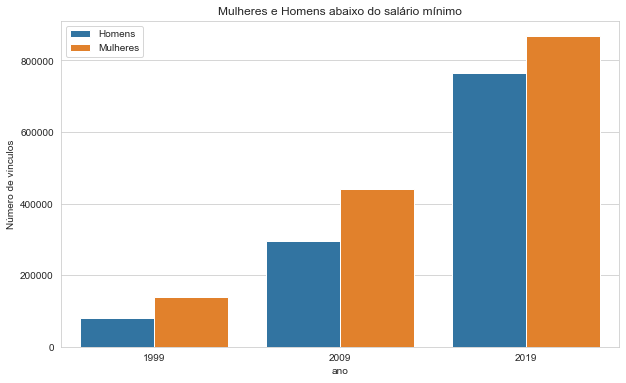

In [193]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
plot_abaixo_sm = sns.barplot(x="ano",
                             y="numero_vinculos",
                             data=trabalhadores_abaixo_sm,
                             hue="sexo_trabalhador", estimator=np.sum, ci=None)
plt.legend(["Homens", "Mulheres"])
plt.ylabel("Número de vínculos")
plt.title("Mulheres e Homens abaixo do salário mínimo")

### Proporção mulheres e homens abaixo do salário mínimo:

In [286]:
propor_abaixo_sm = pd.concat([
    (abaixo_sm_sexo_ano[1]/comp_vinc_ano[1])*100,
    (abaixo_sm_sexo_ano[2]/comp_vinc_ano[2])*100
], axis=1)

propor_abaixo_sm.columns = ["Homens abaixo do sm", "Mulheres abaixo do sm"]
propor_abaixo_sm

,Homens abaixo do sm,Mulheres abaixo do sm
ano,,
1999,0.541540,1.434776
2009,1.244735,2.619587
2019,2.947314,4.231582


### Comparação da Remuneração nominal no país

#### 1) Comparação das Médias

In [117]:
media_rm_br = agrupado_sexo_ano.apply(pondera_media).rename("Média da Remuneração Nominal")
media_rm_br

ano   sexo_trabalhador
1999  1                    750.499641
      2                    609.478229
2009  1                   1588.113883
      2                   1318.641555
2019  1                   3158.481449
      2                   2724.355038
Name: Média da Remuneração Nominal, dtype: float64

#### 2) Comparação das Medianas

In [118]:
mediana_rm_br = agrupado_sexo_ano.apply(pondera_mediana).rename("Mediana da Remuneração Nominal")
mediana_rm_br

ano   sexo_trabalhador
1999  1                    454.801889
      2                    387.360000
2009  1                    947.475000
      2                    804.134000
2019  1                   1967.100000
      2                   1714.187500
Name: Mediana da Remuneração Nominal, dtype: float64

#### 3) Tabelas completa: Média e Mediana

In [237]:
newMultIndex = [(gen, ano) for ano in (1999, 2009, 2019) for gen in ("Homens", "Mulheres")] 
descricao_sexo_ano = pd.concat([media_rm_br, mediana_rm_br], axis=1)
descricao_sexo_ano.index = pd.MultiIndex.from_tuples(newMultIndex)
descricao_sexo_ano

,,Média da Remuneração Nominal,Mediana da Remuneração Nominal
Homens,1999,750.499641,454.801889
Mulheres,1999,609.478229,387.360000
Homens,2009,1588.113883,947.475000
Mulheres,2009,1318.641555,804.134000
Homens,2019,3158.481449,1967.100000
Mulheres,2019,2724.355038,1714.187500


#### 4) Salário da mulher em relação ao homem

In [262]:
dict_aumento_rm = {}
for ano in (1999, 2009, 2019):
    media_homens = descricao_sexo_ano["Média da Remuneração Nominal"][("Homens", ano)]
    media_mulheres= descricao_sexo_ano["Média da Remuneração Nominal"][("Mulheres", ano)]
    mediana_homens = descricao_sexo_ano["Mediana da Remuneração Nominal"][("Homens", ano)]
    mediana_mulheres= descricao_sexo_ano["Mediana da Remuneração Nominal"][("Mulheres", ano)]
    dict_aumento_rm[ano] = [
        f"{(1 - media_mulheres/media_homens) * 100:.2f}%",
        f"{(1 - mediana_mulheres/mediana_homens) * 100:.2f}%"
    ]

salario_mulher_homem = pd.DataFrame(dict_aumento_rm, index={"Média", "Medina"})
salario_mulher_homem

,1999,2009,2019
Média,18.79%,16.97%,13.74%
Medina,14.83%,15.13%,12.86%


### Comparação Remuneração nominal regiões:

In [247]:
regioes= {
    "norte": ["AC", "AP", "AM", "PA", "RO", "RR", "TO"],
    "nordeste": ["AL", "BA", "CE", "MA", "PB", "PE", "PI", "RN", "SE"],
    "centro_oeste": ["DF", "GO", "MT", "MS"],
    "sudeste":["RJ", "SP", "MG", "ES"],
    "sul": ["PR", "RS", "SC"]
}


In [260]:
dict_aumento_rm_reg = {}
for reg in regioes:
    vinculos_reg = agregado_vinculos.loc[agregado_vinculos["sigla_uf"].isin(regioes[reg])]
    vinculos_reg =  vinculos_reg.groupby(by=["ano", "sexo_trabalhador"]).apply(pondera_media)
    vinculos_reg_porc_1999 = (vinculos_reg[(1999, 2)]/vinculos_reg[(1999, 1)])
    vinculos_reg_porc_2019 = (vinculos_reg[(2019, 2)]/vinculos_reg[(2019, 1)])
    dict_aumento_rm_reg[reg] = f"{(vinculos_reg_porc_2019/vinculos_reg_porc_1999 - 1) * 100:.2f}%"


In [261]:
salario_mulher_homem_reg = pd.Series(dict_aumento_rm_reg)
salario_mulher_homem_reg

norte            9.77%
nordeste        17.33%
centro_oeste    -0.40%
sudeste          1.40%
sul              6.02%
dtype: object